# HOW TO obtain data given parameters extracted from an ESO catalogue

The ESO Archive provides access to reduced or fully calibrated data sets, and derived catalogs, that were contributed by PIs of ESO programmes or produced by ESO (using ESO calibration pipelines with the best available calibration data), and then integrated into the ESO Science Archive Facility (see for instance the [ESO catalogue facility](https://www.eso.org/qi/) and the [Archive Science Portal](http://archive.eso.org/scienceportal/home) web-pages).

A powerful way to access this data is the so-called [_programmatic access_](http://archive.eso.org/programmatic/#TAP) via the `tap_cat` and `tap_obs` services. `archive_catalogues` and `archive_observations` are python wrappers part of the un-official [ESOAsg package](https://github.com/EmAstro/ESOAsg). These are built to facilitate the integration of the ESO archive tools within your python environment.

In [1]:
from ESOAsg.ancillary import astro
from ESOAsg import archive_observations
from ESOAsg import archive_catalogues

from astropy.coordinates import SkyCoord
from astropy.io import fits
import astropy.units as u
import matplotlib.pyplot as plt
import numpy as np

In [2]:
%matplotlib notebook

In [3]:
%load_ext autoreload
%autoreload 2

## Get all archival spectra of the most metal poor stars in the GAIA-ESO catalogue

In this example we will show how to get the spectra of the most metal poor stars ([Fe/H]<-2.5dex) present in the [GAIA-ESO public spectroscopic survey](http://www.eso.org/sci/publications/announcements/sciann17031.html).

### Query the GAIA-ESO catalogue

To begin, you need to know the name of the table where the information are stored. For this, you can either check the [query interface webpage](https://www.eso.org/qi/) or you can obtain an astropy table of all catalogues (most recent versions only) using:
```python
archive_catalogues.all_catalogues_info(all_versions=False)
```

In [4]:
all_catalogues = archive_catalogues.all_catalogues_info(all_versions=False)

Now `all_catalogues` contains all the latest version of the catalogues currently present at ESO and you can now look for that `table_name` associated with the `GAIAESO` collection:

In [5]:
all_catalogues['collection', 'table_name', 'title', 'version'].show_in_notebook(show_row_index=False, display_length=5)

collection,table_name,title,version
196.D-0214,EREBOS_RV_cat_fits_V1,EREBOS_RV_cat.fits,1
196.D-0214,EREBOS_cat_fits_V1,EREBOS_cat.fits,1
AMBRE,AMBRE_V1,Atmospheric Parameters and Chemical Abundances from Stellar Spectra,1
ATLASGAL,ATLASGAL_V1,ATLASGAL - APEX Large Area Survey of the Galaxy,1
GAIAESO,GES_iDR4_PIII2016_Catalogue_v3_fits_V2,Gaia-ESO spectroscopic survey,2
GCAV,gcav_rxcj1515_YJKs_cat_fits_V1,GCAV catalogue for RXCJ1514.9-1523 cluster,1
GCAV,gcav_rxcj2129_YJKs_cat_fits_V1,GCAV catalogue for RXCJ2129.6+0005 cluster,1
GOODS_FORS2,GOODS_FORS2_V1,GOODS/FORS2 Spectroscopic Survey,1
GOODS_ISAAC,GOODS_ISAAC_V1,GOODS/ISAAC imaging,1
GOODS_VIMOS_SPEC,GOODS_VIMOS_SPEC_V1,GOODS/VIMOS Spectroscopic Survey,1


The `table_name` that we are going to explore is thus:
```python
table_gaiaeso = 'GES_iDR4_PIII2016_Catalogue_v3_fits_V2'
```
The corresponding acknowledgment for this survey is in the `acknowledgment` field:

In [6]:
gaiaeso_catalogue = archive_catalogues.catalogues_info(tables='GES_iDR4_PIII2016_Catalogue_v3_fits_V2')
table_gaiaeso = gaiaeso_catalogue['table_name'].data[0]
acknowledgment_gaiaeso = gaiaeso_catalogue['acknowledgment'].data[0]
print('The name of the table is: {}. \nThe corresponding acknowledgment is:\n{}.'.format(
    table_gaiaeso, acknowledgment_gaiaeso))

The name of the table is: GES_iDR4_PIII2016_Catalogue_v3_fits_V2. 
The corresponding acknowledgment is:
Please include the following acknowledgment in any published material that makes use of this data products: Based on observations made with ESO Telescopes at the La Silla or Paranal Observatories under programme ID(s) 072.D-0337(A), 072.D-0507(A), 072.D-0777(A), 073.D-0100(A), 073.D-0211(A), 073.D-0760(A), 075.C-0256(A), 075.D-0492(A), 076.B-0263(A), 077.C-0655(A), 077.D-0246(A), 077.D-0484(A), 078.D-0825(A), 078.D-0825(B), 078.D-0825(C), 079.B-0721(A), 079.D-0178(A), 079.D-0645(A), 079.D-0674(A), 079.D-0674(B), 079.D-0674(C), 080.B-0489(A), 080.B-0784(A), 081.D-0253(A), 081.D-0287(A), 082.D-0726(A), 083.B-0083(A), 083.D-0208(A), 083.D-0671(A), 083.D-0798(B), 084.D-0470(A), 084.D-0693(A), 085.D-0205(A), 086.D-0141(A), 087.D-0230(A), 087.D-0276(A), 088.B-0403(A), 088.C-0239(A), 088.D-0026(A), 088.D-0026(C), 088.D-0026(D), 089.D-0038(A), 089.D-0579(A), 187.B-0909(A), 188.B-3002(A), 188

You can now explore the content of a catalogue by checking the columns present in the selected table using:
```python
archive_catalogues.columns_in_catalogue(table_name)
```
The `GAIAESO` table contains:

In [7]:
columns_gaiaeso = archive_catalogues.columns_info(tables=table_gaiaeso)
columns_gaiaeso['column_name', 'description'].show_in_notebook(show_row_index=False, display_length=5)

column_name,description
CNAME,GES object name from coordinates
GES_FLD,GES field name from CASU
OBJECT,GES object name from OB
GES_TYPE,GES Classification System of Target Programmes
SETUP,Grating setups used for analysis
RA,Object Right Ascension
DECLINATION,Object Declination
VRAD,Radial Velocity
E_VRAD,Error on VRAD
TEFF,Effective Temperature


At the moment, we want to see where the most metal poor stars lie in the $T_{eff}$ vs. $\log g$ plane, so we limit our search to the following columns (and to the first 10 entries): 
```python
selected_columns = ['CNAME', 'RA', 'DECLINATION', 'VRAD', 'TEFF', 'LOGG', 'FEH', 'J_2MASS']
```
The content of these columns can be collected by using:
```python
archive_catalogues.get_catalogues(tables=table_name, columns=selected_columns, maxrec=10)
```

In [8]:
selected_columns = ['CNAME', 'RA', 'DECLINATION', 'VRAD', 'TEFF', 'LOGG', 'FEH', 'J_2MASS']
GAIAESO = archive_catalogues.get_catalogues(tables=table_gaiaeso, columns=selected_columns, maxrec=10)

[INFO]    :: The query to GES_iDR4_PIII2016_Catalogue_v3_fits_V2 returned 10 entries (with a limit set to maxrec=10)


The result is thus stored in an `astropy.table`:

In [9]:
GAIAESO.show_in_notebook(show_row_index=False, display_length=10)

CNAME,RA,DECLINATION,VRAD,TEFF,LOGG,FEH,J_2MASS
,Degrees,Degrees,km / s,K,dex,dex,mag
16153746-0822162,243.9060833333292,-8.371166666666525,12.513608,5800.0,4.391,0.082,--
06404486-1633492,100.18691666666498,-16.56366666666639,61.717495,--,--,--,13.747
06410805-1635462,100.28354166666499,-16.596166666666388,30.814867,--,--,--,13.313
06410841-1629195,100.285041666665,-16.488749999999722,137.48524,4998.0,2.528,-0.308,13.559
06411476-1623553,100.31149999999832,-16.398694444444164,137.44228,--,--,--,13.962
06411486-1627268,100.31191666666498,-16.457444444444164,105.07349,--,--,--,13.626
06411990-1627372,100.33291666666499,-16.460333333333057,41.31324,--,--,--,12.932
06412105-1629038,100.33770833333165,-16.484388888888606,135.7489,4196.0,1.493,-0.43,11.369
06412220-1630479,100.3424999999983,-16.513305555555274,134.79945,--,--,--,13.564


### Find metal poor stars:

Now the `GAIAESO` catalogue is ready to be explored. As an example, we queried a larger fraction of the catalogue to find the most metal poor stars (with $[Fe/H]<-2.5\,dex$) and to see their location in the $T_{eff}$ vs. $\log g$ plane:

[INFO]    :: The query to GES_iDR4_PIII2016_Catalogue_v3_fits_V2 returned 25533 entries (with a limit set to maxrec=25533)


<IPython.core.display.Javascript object>


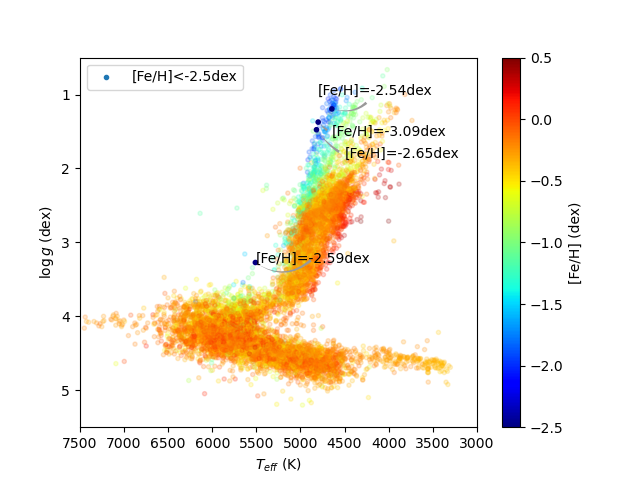

In [16]:
METAL_LIMIT = -2.5 # limit in Fe/H to select metal poor stars

GAIAESO = archive_catalogues.get_catalogues(tables=table_gaiaeso, columns=selected_columns, maxrec=None)

# extract the info
TEFF = GAIAESO['TEFF'].data
LOGG = GAIAESO['LOGG'].data
META = GAIAESO['FEH'].data
# remove nans
filter_nans = np.isfinite(TEFF) & np.isfinite(LOGG) & np.isfinite(META)
TEFF, LOGG, META = TEFF[filter_nans], LOGG[filter_nans], META[filter_nans]


# plot the result
plt.figure()
plt.xlim(7500.,3000.)
plt.ylim(5.5,0.5)
plt.scatter(TEFF, LOGG, c=META, alpha=0.2, marker='.', 
            cmap='jet')
plt.scatter(TEFF[(META<METAL_LIMIT)], LOGG[(META<METAL_LIMIT)], c=META[(META<METAL_LIMIT)], alpha=1., marker='.', 
            cmap='jet', label=r'[Fe/H]<{}dex'.format(METAL_LIMIT))
plt.clim(-2.5,0.5)
cbar = plt.colorbar()
cbar.set_label(r'[Fe/H] (dex)')
plt.xlabel(r'$T_{eff}$ (K)')
plt.ylabel(r'$\log\,g$ (dex)')
plt.legend()
for idx in range(len(TEFF[(META<METAL_LIMIT)])):
    plt.annotate(r'[Fe/H]={:.2f}dex'.format(META[(META<METAL_LIMIT)][idx]), 
                 xy=(TEFF[(META<METAL_LIMIT)][idx], LOGG[(META<METAL_LIMIT)][idx]),
                 xytext=(-(idx-2)*10, (idx-2)*10), textcoords='offset points',
                 arrowprops=dict(arrowstyle="wedge,tail_width=0.2",
                                 fc="0.6", ec="none",
                                 connectionstyle="arc3,rad=-0.4"))
plt.show()
plt.savefig('gaiaeso.jpg', format='jpg', quality=99, bbox_inches='tight')

In the `GAIAESO` catalogue there are thus 5 metal poor stars (note that 19101103-5955405 does not appear in the plot above because does not have a finite values for LOGG). The properties of which can be checkd by slicing the `GAIAESO` table:

In [17]:
select_metal_poor = (GAIAESO['FEH'].data<METAL_LIMIT)
GAIAESO[select_metal_poor].show_in_notebook(show_row_index=False, display_length=5)

/scratch/Extern/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in less
  """Entry point for launching an IPython kernel.


CNAME,RA,DECLINATION,VRAD,TEFF,LOGG,FEH,J_2MASS
,Degrees,Degrees,km / s,K,dex,dex,mag
18361733-2700053,279.07220833332855,-27.001472222221764,26.7687,4818.0,1.476,-2.654,12.096
20024625-4544023,300.69270833332826,-45.733972222221446,-45.692577,4799.0,1.3723,-3.0866,14.12
15430220-1056042,235.75899999999604,-10.934527777777594,-170.4696,5511.0,3.272,-2.594,--
21294377+1208333,322.4323749999945,12.14258333333313,-101.8468,4644.0,1.194,-2.537,12.501
19101103-5955405,287.5459583333285,-59.92791666666565,-30.11368,4382.0,--,-2.75,15.814


### Find science ready spectra of the selected stars

Now we want to have on disk all the spectroscopic data present in the ESO archive that targeted the selected metal poor stars. This could be done with the function <code>archive_observations.query_from_radec</code>. This will allow you to investigate the presence of processed data within a certain radius in arcseconds (e.g., `radius=5.`) from a given position. The position of the star is given as an `astropy.SkyCoord` object that could be created simply using:
```python
SkyCoord(ra=235.758999*u.degree, dec=-10.934527*u.degree)
```
We will thus first create a list of positions and then query the archive (given that the goal is to obtain the reduced spectra we limit the search to `data_type='spectrum'`):

In [18]:
star_positions = []
for RA_STAR, DEC_STAR in zip(GAIAESO[select_metal_poor]['RA'].data, GAIAESO[select_metal_poor]['DECLINATION'].data):
    star_positions.append(SkyCoord(ra=RA_STAR*u.degree, dec=DEC_STAR*u.degree))
result_from_queries = archive_observations.query_from_radec(star_positions, radius=5., 
                                                            data_types= 'spectrum', verbose=False)   

AttributeError: module 'ESOAsg.archive_observations' has no attribute 'query_from_radec'

The result is stored in a list of astropy tables (one per star) containing relevant informations on the data collected.

For instanece, for the famous star [HD 140283](https://simbad.u-strasbg.fr/simbad/sim-id?Ident=HD+140283) (the 3rd in the list) the ESO archive contains **285 spectra** collected with the instruments 'GIRAFFE', 'UVES', and 'XSHOOTER':

In [ ]:
result_from_queries[2].show_in_notebook(show_row_index=False, display_length=5)

#### Bonus: the Archive Science Portal (ASP)

As a complementary approach, you can also explore the [Archive Science Portal](http://archive.eso.org/scienceportal/home) at specific locations. This could be done by running:

```python
archive_observations.query_ASP_from_radec(position_list, radius=5., open_link=True)
```

This should open different [Archive Science Portal](http://archive.eso.org/scienceportal/home) pages in your broswer (one per positions) pointing to the different regions of the sky you are quering.

In [ ]:
archive_observations.query_ASP_from_radec(star_positions, radius=5., open_link=True)

### Download science ready spectra of the selected stars

Now it is time to download the spectra that you are interested in. This is done by feeding the `dp_id` column to `archive_observations.download`.

If you want to explore the region around the the H$\alpha$ line, you can limit the download to optical data only. This is done by selecting the limit in the wavelength coverage:

`em_min>4.0e-7 & em_max<1.2e-6`

where wavelengths are expressed in meters (to be compliant with the VO standard). In other words, we are limiting the wavelength coverage to:

$4000 \mathring A < \lambda < 12000 \mathring A$

In [ ]:
mask_optical = (result_from_queries[2]['em_max'].data.data < 1.2e-6 ) & \
    ( result_from_queries[2]['em_min'].data.data > 4.0e-7 )
archive_observations.download(result_from_queries[2]['dp_id'][mask_optical])

### Explore your data

Now you have all the optical spectra on your disk and it is time to explore them! Here we read in all files and plot the spectral regions around the H$\alpha$ line. Note that given that the `GIRAFFE` data are not flux calibrated we show only the normalized spectra.

In [ ]:
# Load data
def extract_spectrum(fits_file):
    speed_of_light = 299792.458 # km/s
    spectrum = fits.open(fits_file)[1]
    instrument = fits.open(fits_file)[0].header['INSTRUME']
    # Shifting to Ang.
    if fits.open(fits_file)[1].header['TUNIT1'] == 'nm':
        wl_corr = 10.
    else:
        wl_corr = 1.
    # Check if it is necessary to perform the heliocentric correction:
    try:
        specsys = fits.open(fits_file)[0].header['SPECSYS']
        print(' - SPECSYS: {}'.format(specsys))
        if specsys != 'HELIOCEN':
            try:
                for keyword in ['HIERARCH ESO QC VRAD HELICOR', 'HELICORR']:
                    if keyword in fits.open(fits_file)[0].header:
                        helicor = fits.open(fits_file)[0].header[keyword]
            except:
                helicor = 0.
        else:
            wl_corr = wl_corr
            helicor = 0.
    except:
        print(' - SPECSYS not valid')        
        wl_corr = -1.
        helior = 0.    
    if instrument == 'XSHOOTER':
        wl_corr, fl_corr = wl_corr * (1. + (helicor/speed_of_light)), 1.
        spectrum_wave = spectrum.data['WAVE'][0] * wl_corr
        spectrum_flux = spectrum.data['FLUX'][0] * fl_corr
        spectrum_err = spectrum.data['ERR'][0] * fl_corr   
    elif instrument == 'GIRAFFE':
        wl_corr, fl_corr = wl_corr * (1. + (helicor/speed_of_light)), 1.
        wl_corr, fl_corr = wl_corr * (1. + (helicor/speed_of_light)), 1.
        spectrum_wave = spectrum.data['WAVE'][0] * wl_corr
        try:
            spectrum_flux = spectrum.data['FLUX_REDUCED'][0] * fl_corr
            spectrum_err = spectrum.data['ERR_REDUCED'][0] * fl_corr
        except:
            spectrum_flux = spectrum.data['FLUX'][0] * fl_corr
            spectrum_err = spectrum.data['ERR'][0] * fl_corr
    elif instrument == 'UVES':
        wl_corr, fl_corr = wl_corr * (1. + (helicor/speed_of_light)), 1e-16
        spectrum_wave = spectrum.data['WAVE'][0] * wl_corr
        spectrum_flux = spectrum.data['FLUX'][0] * fl_corr
        spectrum_err = spectrum.data['ERR'][0] * fl_corr 
    else:
        print(' - instrument not known')
        print(fits_file)
        wl_corr, fl_corr = 0., 0.
        spectrum_wave = 0.
        spectrum_flux = 0.
        spectrum_err = 0.
    if helicor>0.:
        print(' - heliocentric correction of {:.2f} km/s applyed'.format(helicor))
    return spectrum_wave, spectrum_flux, spectrum_err, instrument 

In [ ]:
# XSHOOTER
# Plor re-normalized spectra
plt.figure()
for spectrum_name in result_from_queries[2]['dp_id'][mask_optical]:
    print('File: {}'.format(spectrum_name))
    spectrum_wave, spectrum_flux, spectrum_err, instrument = extract_spectrum(spectrum_name+'.fits')
    print(' - instrument: {}'.format(instrument))
    # normalize to 1 the flux between 6575 and 6585
    try:
        normalize_region = (spectrum_wave>6575.) & (spectrum_wave<6585.)
        if len(spectrum_flux[normalize_region])>0:
            normalize_spectrum = np.nanmedian(spectrum_flux[normalize_region])
            spectrum_vel = (spectrum_wave/6562.793 - 1.) * 299792.458
            if instrument == 'XSHOOTER':
                pcolor = 'orange'
            elif instrument == 'GIRAFFE':
                pcolor = 'darkblue'
            else:
                pcolor = 'red'
            plt.plot(spectrum_vel, spectrum_flux/normalize_spectrum, c=pcolor, label=instrument, alpha=0.5)
        else:
            print(' - spectrum not covering the plotting range')
    except:
        print(' - spectrum not plotted')        
radial_velocity = -170.37 # km/s
plt.axvspan(radial_velocity-0.8, radial_velocity+0.8, alpha=0.5, color='darkgrey')        
plt.xlim(-370., +30.)
plt.ylim(0., 1.3)
plt.xlabel(r'Velocity Relative to H$\alpha$ [km s$^{-1}$]')
plt.ylabel(r'Normalized Flux')
handles, labels = plt.gca().get_legend_handles_labels()
unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
plt.legend(*zip(*unique))
plt.title(r'HD 140283 $-$ H$\alpha$')
plt.text(radial_velocity, 0.05, r'RV = (-170.37$\pm$0.15) km s$^{-1}$', horizontalalignment='right')
plt.show()
plt.savefig('HD140283.jpg', format='jpg', quality=99, bbox_inches='tight')